# SHANTIH MLP

# CODE TO START NORMALIZING TEST AND RUN ALL

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os
import math
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import RobustScaler


### Need to add the cse-251-b-2025 folder in the root directory and make sure it has the two .npz files.

In [4]:
train_file = np.load('./cse-251-b-2025/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)

test_file = np.load('./cse-251-b-2025/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


### FEATURES
These methods build the dataset with different types of features. Some are just the positions, some are the deltas, some are neighbours, some add noise to the features, kinda modify the return of the methods to get what you want. Mostly using those to return the features cause the labels will be the positions minus the 50th position for all models.

In [61]:
def get_set_with_velocity_and_neighbors(data, k=5):
    positions = data[..., :2].copy()  # Extract (x, y) only
    past_positions = positions[:, 0, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = positions[:, 0, 50:, :].copy()  # (scenarios, 60, 2)
    reference = positions[:, 0, 49, :].copy() # (scenarios, 2)

    # Compute velocity between consecutive timesteps (t1 - t0, t2 - t1, ...)
    velocities = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)

    # Get position of all agents at timestep 50
    agents_at_t50 = positions[:, :, 49, :]  # (scenarios, 50, 2)
    primary_at_t50 = agents_at_t50[:, 0, :]  # (scenarios, 2)
    others_at_t50 = agents_at_t50[:, 1:, :]  # (scenarios, 49, 2)

    # Mask out agents with (0,0) position
    valid_mask = ~(others_at_t50 == 0).all(axis=2)  # (scenarios, 49)
    diffs = others_at_t50 - primary_at_t50[:, None, :]  # (scenarios, 49, 2)
    dists = np.linalg.norm(diffs, axis=2)  # (scenarios, 49)
    dists[~valid_mask] = np.inf

    # Get 5 closest
    nearest_idxs = np.argpartition(dists, kth=5, axis=1)[:, :5]  # (scenarios, 5)
    batch_indices = np.arange(data.shape[0])[:, None]
    closest_diffs = diffs[batch_indices, nearest_idxs]  # (scenarios, 5, 2)

    # subtract the 50th position from past and future positions
    past_positions -= reference[:, None, :] # (scenarios, 50, 2)
    future_positions -= reference[:, None, :] # (scenarios, 60, 2)

    # Final feature shape: (scenarios, 50+49+5, 2)
    # removed closest_diffs
    all_features = np.concatenate([past_positions, velocities[:, -10:, :]], axis=1)
    return all_features, future_positions

def get_delta_to_delta_dataset(data):
    positions = data[..., :2].copy()  # (scenarios, agents, timesteps, 2)
    
    # Extract primary agent's trajectory
    primary_traj = positions[:, 0, :, :].copy()  # (scenarios, timesteps=110, 2)

    # Split into past and future
    past_positions = primary_traj[:, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = primary_traj[:, 49:, :].copy()  # (scenarios, 60, 2)

    # Compute deltas (velocities)
    past_deltas = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)
    future_deltas = future_positions[:, 1:, :] - future_positions[:, :-1, :]  # (scenarios, 59, 2)

    smoothed_past_deltas = np.zeros_like(past_deltas)
    for t in range(past_deltas.shape[1]):
        # Average over the current and next 3 timesteps
        end_idx = min(t + 3, past_deltas.shape[1])
        smoothed_past_deltas[:, t, :] = np.mean(past_deltas[:, t:end_idx, :], axis=1)

    return smoothed_past_deltas, future_deltas

def get_delta_to_delta_dataset_with_dist(data, k=5, epsilon=3.0):
    positions = data[..., :2].copy()  # (scenarios, agents, timesteps, 2)

    # Primary agent trajectory
    primary_traj = positions[:, 0, :, :].copy()  # (scenarios, 110, 2)
    past_positions = primary_traj[:, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = primary_traj[:, 49:, :].copy()  # (scenarios, 61, 2)

    # Deltas
    past_deltas = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)
    future_deltas = future_positions[:, 1:, :] - future_positions[:, :-1, :]  # (scenarios, 60, 2)

    # Agent positions at t=49 and t=50
    agents_at_t49 = positions[:, :, 48, :]  # (scenarios, agents, 2)
    agents_at_t50 = positions[:, :, 49, :]  # (scenarios, agents, 2)

    primary_at_t50 = agents_at_t50[:, 0, :]  # (scenarios, 2)
    others_at_t50 = agents_at_t50[:, 1:, :]  # (scenarios, agents-1, 2)
    others_at_t49 = agents_at_t49[:, 1:, :]  # (scenarios, agents-1, 2)

    # Compute relative positions and distances
    diffs = others_at_t50 - primary_at_t50[:, None, :]  # (scenarios, agents-1, 2)
    dists = np.linalg.norm(diffs, axis=2)  # (scenarios, agents-1)

    # Mask out invalid agents (all-zero position at t=50)
    valid_mask = ~(others_at_t50 == 0).all(axis=2)  # (scenarios, agents-1)
    dists[~valid_mask] = np.inf

    # Sort by distance
    sorted_idxs = np.argsort(dists, axis=1)[:, :k]  # (scenarios, k)
    batch_indices = np.arange(data.shape[0])[:, None]

    sorted_diffs = diffs[batch_indices, sorted_idxs]  # (scenarios, k, 2)
    sorted_dists = dists[batch_indices, sorted_idxs]  # (scenarios, k)
    sorted_valid = sorted_dists <= epsilon  # (scenarios, k)

    # Unit direction to ego (a, b)
    unit_vectors = np.zeros_like(sorted_diffs)
    norm_mask = (sorted_dists > 1e-6) & sorted_valid
    unit_vectors[norm_mask] = sorted_diffs[norm_mask] / sorted_dists[norm_mask][..., None]

    # Raw deltas for neighbors between t=49 and t=50 (c, d)
    velocity_deltas = others_at_t50 - others_at_t49  # (scenarios, agents-1, 2)

    # Mask out invalid deltas: agent must exist at both t=49 and t=50
    valid_prev_mask = ~(others_at_t49 == 0).all(axis=2)  # (scenarios, agents-1)
    valid_both_mask = valid_mask & valid_prev_mask  # both t=49 and t=50 must be valid
    velocity_deltas[~valid_both_mask] = 0

    sorted_velocities = velocity_deltas[batch_indices, sorted_idxs]  # (scenarios, k, 2)

    # Combine (a, b) and (c, d) → shape: (scenarios, k, 4)
    neighbor_features = np.concatenate([unit_vectors, sorted_velocities], axis=2)

    # Final features: past deltas + k * 2 rows of neighbor features
    neighbor_features_reshaped = neighbor_features.reshape(data.shape[0], k * 2, 2)  # 2 rows per neighbor

    # Compute average deltas over the last 5, 10, 15, 20 time steps
    avg_1 = past_deltas[:, -1:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_2 = past_deltas[:, -2:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_3 = past_deltas[:, -3:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_4 = past_deltas[:, -4:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_5 = past_deltas[:, -5:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_5 = past_deltas[:, -5:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_6 = past_deltas[:, -6:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_7 = past_deltas[:, -7:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_8 = past_deltas[:, -8:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_9 = past_deltas[:, -9:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_10 = past_deltas[:, -10:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_15 = past_deltas[:, -15:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_20 = past_deltas[:, -20:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_25 = past_deltas[:, -25:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_30 = past_deltas[:, -30:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_35 = past_deltas[:, -35:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_40 = past_deltas[:, -40:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_45 = past_deltas[:, -45:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_50 = past_deltas[:, -50:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_55 = past_deltas[:, -55:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_60 = past_deltas[:, -60:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)

    #avg_deltas = np.concatenate([avg_1, avg_3, avg_5, avg_10, avg_15, avg_20, avg_25, avg_30, avg_35, avg_40, avg_45, avg_50, avg_55, avg_60], axis=1)  # (scenarios, 4, 2)
    avg_deltas = np.concatenate([avg_1, avg_2, avg_3, avg_4, avg_5, avg_10], axis=1)  # (scenarios, 4, 2)

    angles_48 = data[:, 0, 48, 4].copy() / np.pi  # (scenarios,)
    angles_49 = data[:, 0, 49, 4].copy() / np.pi  # (scenarios,)
    angles_47 = data[:, 0, 47, 4].copy() / np.pi  # (scenarios,)
    angles_46 = data[:, 0, 46, 4].copy() / np.pi  # (scenarios,)
    angles_45 = data[:, 0, 45, 4].copy() / np.pi  # (scenarios,)
    angles_44 = data[:, 0, 44, 4].copy() / np.pi  # (scenarios,)

    # Stack angles into shape (scenarios, 1, 2)
    angle_features1 = np.stack([angles_44, angles_45], axis=1)[:, None, :]
    angle_features2 = np.stack([angles_46, angles_47], axis=1)[:, None, :]
    angle_features3 = np.stack([angles_48, angles_49], axis=1)[:, None, :]

    #all_features = np.concatenate([past_deltas, avg_deltas], axis=1)  # (scenarios, 49 + 2k, 2)
    #all_features = np.concatenate([past_deltas, avg_deltas, neighbor_features_reshaped, angle_features], axis=1)  # (scenarios, 49 + 2k, 2)
    all_features = np.concatenate([past_deltas], axis=1)  # (scenarios, 49 + 2k, 2)

    return all_features, future_deltas

def get_augmented_delta_to_delta(data):
    positions = data[..., :2].copy()  # (scenarios, timesteps, 2)

    # Split into past and future
    past_positions = positions[:, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = positions[:, 49:, :].copy()  # (scenarios, 60, 2)

    # Compute deltas (velocities)
    past_deltas = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)
    future_deltas = future_positions[:, 1:, :] - future_positions[:, :-1, :]  # (scenarios, 59, 2)

    smoothed_past_deltas = np.zeros_like(past_deltas)

    for t in range(past_deltas.shape[1]):
        # Average over the current and next 3 timesteps
        end_idx = min(t + 3, past_deltas.shape[1])
        smoothed_past_deltas[:, t, :] = np.mean(past_deltas[:, t:end_idx, :], axis=1)

    return smoothed_past_deltas, future_deltas


### Test data
Here I'm just loading the test data and building the features for it

In [62]:
test_x = test_data[:, 0, :50, :2].copy()
print(test_data.shape)

initial_test_x = test_x[:, 49:50, :].copy()

(2100, 50, 50, 6)


In [63]:

#test_x, _ = get_set_with_velocity_and_neighbors(test_data)
#test_x, _ = get_delta_to_delta_dataset_with_dist(test_data, 5, 100)
test_x, _ = get_delta_to_delta_dataset(test_data)

#test_x = np.tanh(test_x)

print(test_x.shape)
print(initial_test_x[0])
print(test_x[0])

(2100, 49, 2)
[[5426.23875074 1467.55349867]]
[[ 4.27986953e-02  1.03151141e-02]
 [ 2.70674479e-04 -2.68911539e-03]
 [ 3.96382459e-03  4.80158170e-03]
 [ 1.82885869e-02  1.45681216e-02]
 [ 7.25056077e-04 -1.36348596e-04]
 [-2.93108517e-02 -2.07581589e-02]
 [-5.15389197e-02 -1.66756215e-02]
 [-1.43666806e-02  1.08294239e-02]
 [-4.15994488e-03  9.06891011e-03]
 [ 1.50342115e-02  2.09693332e-03]
 [ 8.46121246e-03 -1.24365214e-02]
 [ 5.91096384e-03 -8.57995635e-03]
 [-1.07666468e-02 -5.27735620e-03]
 [-5.48006904e-03  1.52006762e-02]
 [ 1.91085453e-02  2.66112428e-02]
 [ 2.42543502e-02  2.42208969e-03]
 [-3.18588096e-02 -5.88529603e-02]
 [-4.95845447e-02 -4.98661476e-02]
 [-1.27123607e-02  7.92841298e-05]
 [ 5.38699053e-02  5.11298438e-02]
 [ 4.45482242e-02  3.20309143e-02]
 [ 1.12813441e-02 -7.81926487e-03]
 [-2.67206657e-03 -7.93793472e-03]
 [ 4.96623367e-03  1.58338848e-02]
 [ 2.16482185e-02  3.34937479e-02]
 [-1.36026364e-03  1.25315270e-02]
 [-1.64031605e-02 -1.09751720e-02]
 [-2.1389

Here I'm just plotting the test features and you can see the noise.

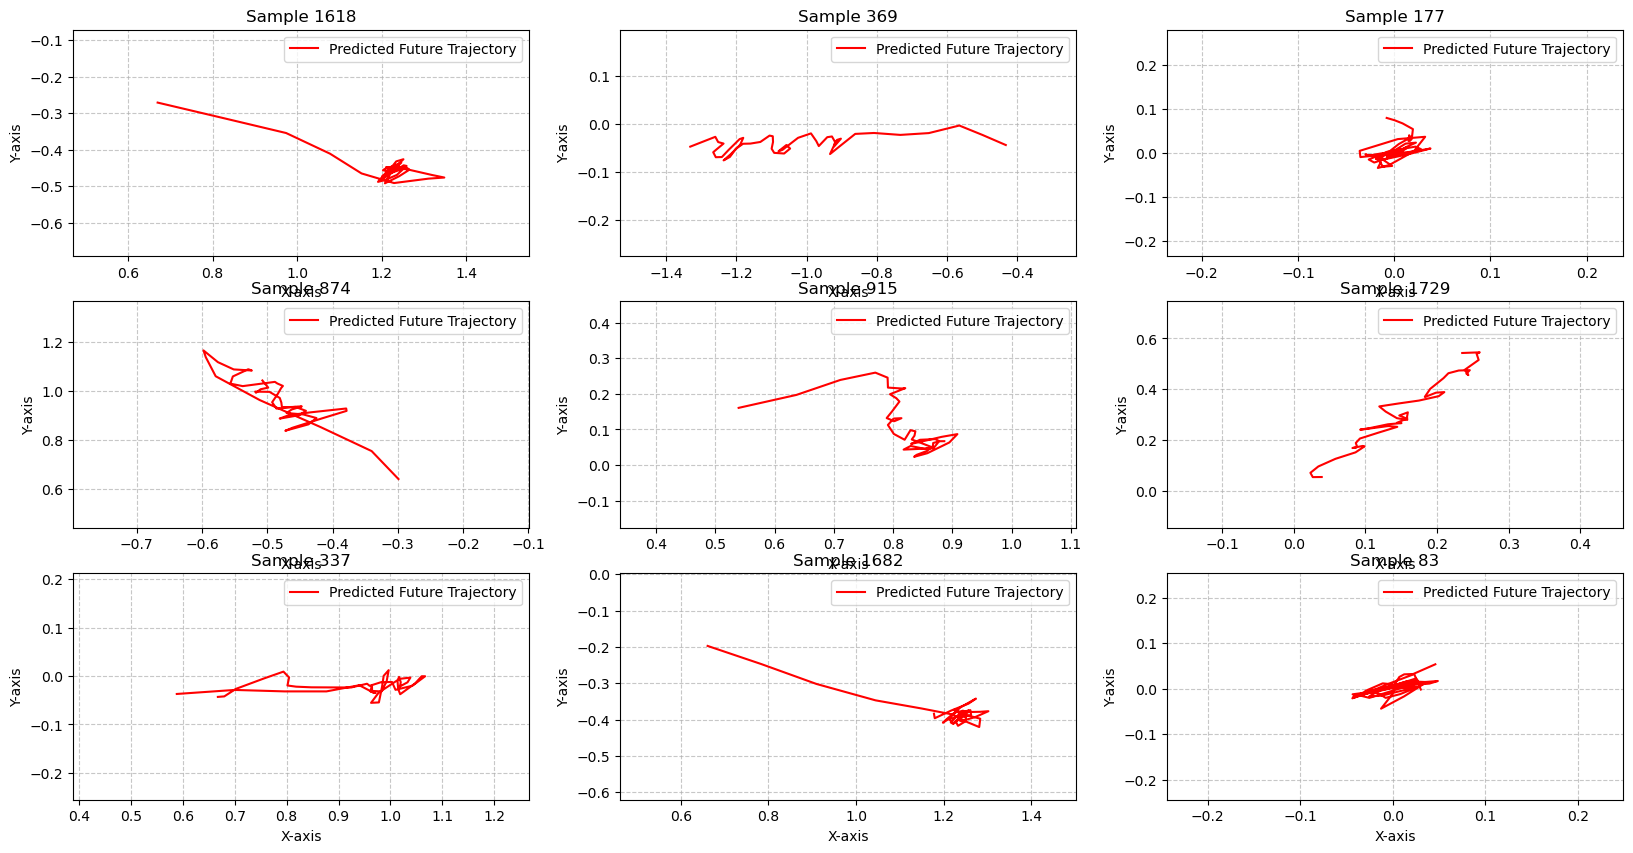

In [70]:
def plot_trajectory(ax, path, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(path[:49,0], path[:49,1], color='red', label='Predicted Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = path[..., 0].max()
    x_min = path[..., 0].min()
    y_max = path[..., 1].max()
    y_min = path[..., 1].min()
    
    ax.set_xlim(x_min - 0.2, x_max + 0.2)
    ax.set_ylim(y_min - 0.2, y_max + 0.2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

random_indices = random.sample(range(test_x.shape[0]), 9)
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects


for i, idx in enumerate(random_indices):

    plot_trajectory(axes[i], test_x[idx], title=f"Sample {idx}")
    axes[i].legend()

plt.show()

### AUGMENT
These methods are used to add a rotation to the paths so we augment the data. You can control how much you augment.

In [48]:
def rotate_path(path, angle_degrees):
    """
    Rotates a 2D path around its centroid.
    Args:
        path (np.ndarray): shape (110, 2)
        angle_degrees (float): rotation angle in degrees
    Returns:
        np.ndarray: rotated path (110, 2)
    """
    # Compute centroid
    centroid = path.mean(axis=0)  # shape (2,)

    # Translate path to origin
    translated = path - centroid

    # Convert angle to radians
    theta = np.radians(angle_degrees)

    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

    # Apply rotation
    rotated = translated @ rotation_matrix.T

    # Translate back to original centroid
    return rotated + centroid

def augment_dataset(data, num_rotations=10, seed=None):
    """
    Augments dataset by rotating each path around its centroid with a random angular offset.
    Args:
        data (np.ndarray): shape (N, 110, 2)
        num_rotations (int): number of total rotations including the original
        seed (int, optional): random seed for reproducibility
    Returns:
        np.ndarray: augmented data of shape (N * num_rotations, 110, 2)
    """
    if seed is not None:
        np.random.seed(seed)

    N = data.shape[0]
    angle_step = 360 / num_rotations
    augmented = []

    for i in range(N):
        path = data[i]
        random_offset = np.random.uniform(0, 360)  # Unique offset per path

        for r in range(num_rotations):
            angle = random_offset + r * angle_step
            rotated_path = rotate_path(path, angle)
            augmented.append(rotated_path)

    return np.stack(augmented)  # shape: (N * num_rotations, 110, 2)

### Training and validation sets
This makes the augmented dataset and calculates the labels by subtracting the position at 50.

In [49]:
#SET TO FALSE IF YOU DONT WANT AUTOREGRESSIVE
auto_regressive = False
#auto_regressive = True

augmented_data = train_data[:, 0, :, :2].copy()
augmented_data = augment_dataset(augmented_data, 35)

#train_x, train_y = train_data[:, 0, :50, :2].copy(), train_data[:, 0, 50:, :2].copy()
train_x, train_y = augmented_data[:, :50, :2].copy(), augmented_data[:, 50:, :2].copy()

print(train_x.shape, train_y.shape)

initial_train_x = train_x[:, 49:50, :].copy()
train_y -= initial_train_x

(350000, 50, 2) (350000, 60, 2)


Here we get the features. Right now its a delta feature but we average every 4 deltas to kinda smooth out the values.

In [ ]:

#adding new velocity and neighbour info
#train_x, train_y = get_set_with_velocity_and_neighbors(train_data)
#train_x, _ = get_delta_to_delta_dataset_with_dist(train_data, 5, 100)
train_x, _ = get_augmented_delta_to_delta(augmented_data)

#scaler = RobustScaler()  # scales based on IQR (25th to 75th percentile)
#scaler = RobustScaler(quantile_range=(5, 90))
#train_x_reshaped = train_x.reshape(-1, train_x.shape[-1])  # reshape to 2D
#scaler.fit(train_x_reshaped)

#train_x = scaler.transform(train_x_reshaped).reshape(train_x.shape)

#train_x = np.tanh(train_x)

print(train_x.shape, train_y.shape)
id = 8
print(train_x[id], train_y[id])

copy_train_x = train_x.copy()

(350000, 49, 2) (350000, 60, 2)
[[ 0.66737864 -0.15381817]
 [ 0.78821186 -0.18186797]
 [ 0.89968448 -0.20784304]
 [ 0.99693834 -0.23058777]
 [ 1.07492312 -0.24890481]
 [ 1.12892216 -0.26167178]
 [ 1.15410009 -0.26776397]
 [ 1.14569264 -0.26610593]
 [ 1.11743509 -0.25986735]
 [ 1.09171269 -0.25416832]
 [ 1.08114999 -0.25191073]
 [ 1.08157596 -0.25216203]
 [ 1.0821365  -0.25243671]
 [ 1.08248327 -0.25260259]
 [ 1.08248908 -0.25258698]
 [ 1.08213145 -0.25239543]
 [ 1.08156518 -0.25211314]
 [ 1.08038162 -0.25171547]
 [ 1.0787508  -0.25130651]
 [ 1.07703193 -0.25095746]
 [ 1.07525311 -0.25061155]
 [ 1.07322188 -0.25016892]
 [ 1.07100505 -0.24962368]
 [ 1.06928179 -0.2491741 ]
 [ 1.06789316 -0.24883708]
 [ 1.06669258 -0.24860707]
 [ 1.06558952 -0.24842318]
 [ 1.06475101 -0.24830698]
 [ 1.0641361  -0.24823081]
 [ 1.06392152 -0.24819526]
 [ 1.06400056 -0.24820917]
 [ 1.06423034 -0.24826675]
 [ 1.06436436 -0.24827261]
 [ 1.06400775 -0.24804521]
 [ 1.06326503 -0.24761627]
 [ 1.06217805 -0.247125

Here we add noise to the training data to mimic what we see in the test data. I also visulize the result below so you can compare with the previous test visualization.

In [71]:
def add_delta_noise(train_x: np.ndarray, noise_std: float = 0.05, clip_range: float = 1.7):
    """
    Adds Gaussian noise to delta features, clipped to the given range.

    Parameters:
    - train_x (np.ndarray): Shape (N, 49, 2), the delta features.
    - noise_std (float): Standard deviation of the noise to apply.
    - clip_range (float): Max absolute value allowed in deltas.

    Returns:
    - np.ndarray: Noisy version of train_x with same shape.
    """
    assert train_x.ndim == 3 and train_x.shape[1:] == (49, 2), "Expected shape (N, 49, 2)"
    
    noise = np.random.normal(loc=0.0, scale=noise_std, size=train_x.shape)
    noisy_x = train_x + noise

    # Clip to stay within or near the original range
    noisy_x = np.clip(noisy_x, -clip_range, clip_range)

    return noisy_x

train_x = add_delta_noise(copy_train_x, 0.02, 1.8)

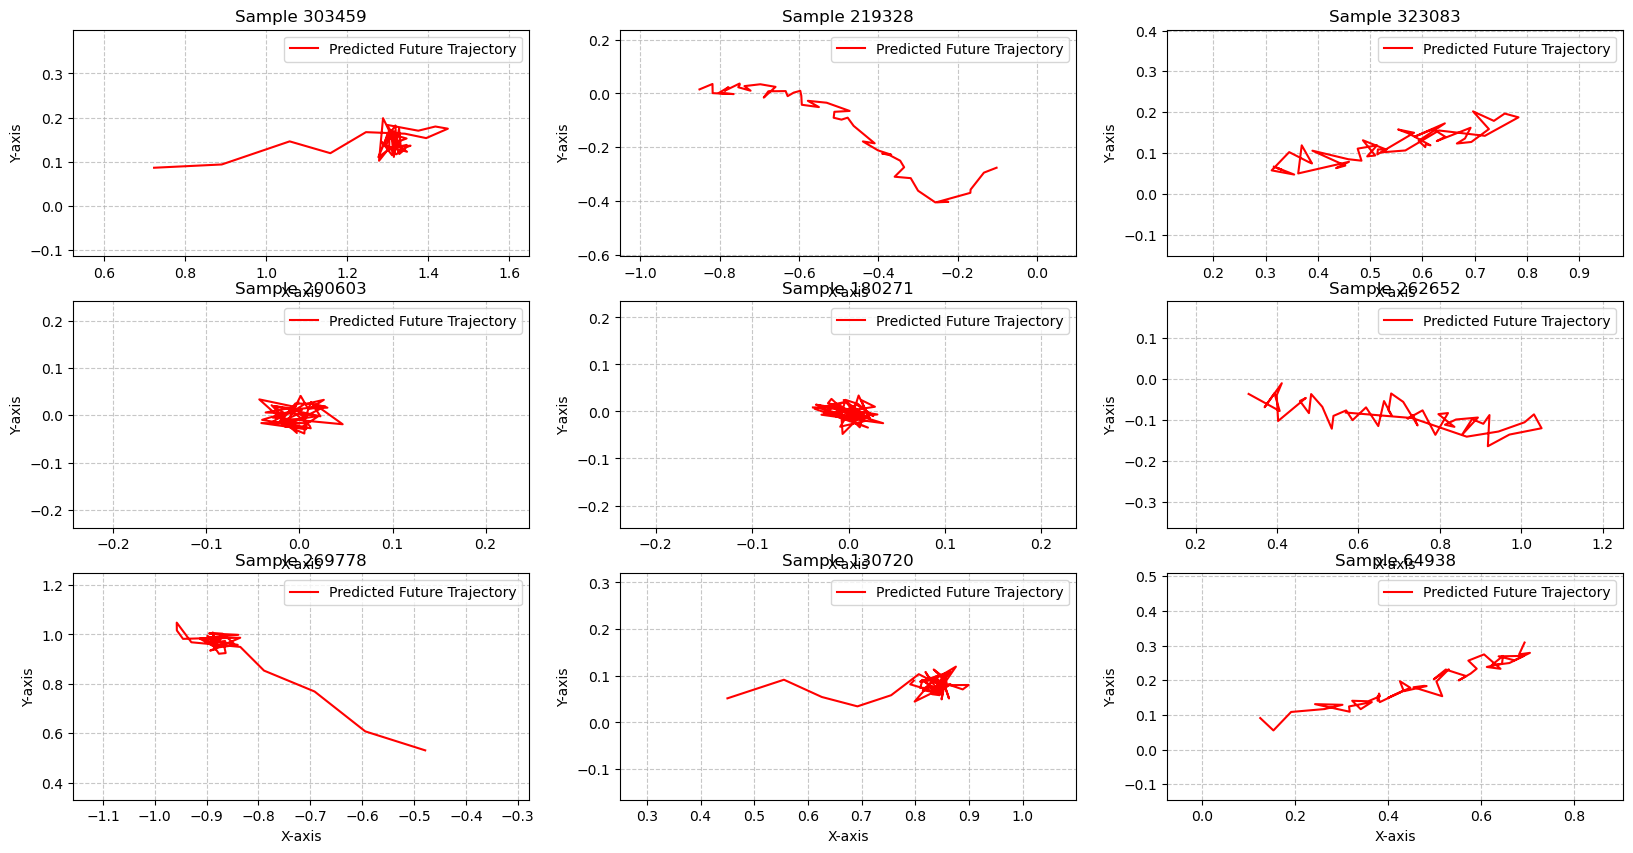

In [73]:
def plot_trajectory(ax, path, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(path[:49,0], path[:49,1], color='red', label='Predicted Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = path[..., 0].max()
    x_min = path[..., 0].min()
    y_max = path[..., 1].max()
    y_min = path[..., 1].min()
    
    ax.set_xlim(x_min - 0.2, x_max + 0.2)
    ax.set_ylim(y_min - 0.2, y_max + 0.2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

random_indices = random.sample(range(train_x.shape[0]), 9)
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects


for i, idx in enumerate(random_indices):
    plot_trajectory(axes[i], train_x[idx], title=f"Sample {idx}")
    axes[i].legend()

plt.show()

# Splitting into train and validation

In [74]:
ratio_validation = 0.1
perm = torch.randperm(train_x.shape[0])
idx = int(ratio_validation * train_x.shape[0])

new_train_x = train_x[perm[idx:]].copy()
new_train_y = train_y[perm[idx:]].copy()

val_x = train_x[perm[:idx]].copy()
val_y = train_y[perm[:idx]].copy()

print(new_train_x.shape, new_train_y.shape)
print(val_x.shape, val_y.shape)

(315000, 49, 2) (315000, 60, 2)
(35000, 49, 2) (35000, 60, 2)


Plot the distribution of the train data

(350000, 49, 2)
(34300000,)
1.7196088808749361
0


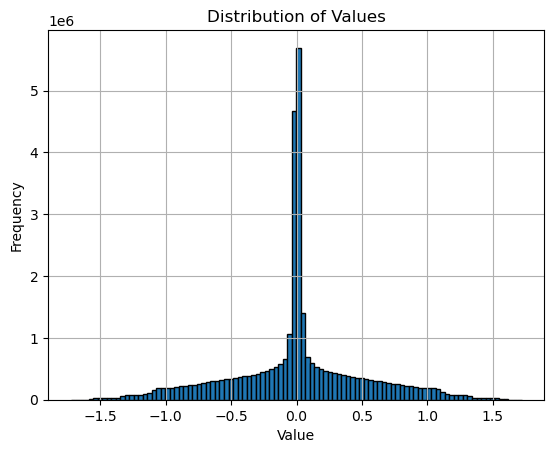

In [75]:
# Example list
values = train_x.flatten().copy()
print(train_x.shape)
print(values.shape)
print(max(values))

limit = 100
outs = [x for x in values if x > limit or x < -limit]
print(len(outs))

plt.hist(values, bins=100, edgecolor='black')
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Code for adding closest agent feature (in progress)

### Play with the number of layers and sizes. My computer takes too long

In [76]:
class ComplexMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(ComplexMLP, self).__init__()

        # Define the layers
        self.input_features = input_features
        self.output_features = output_features
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 2048),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x

## Using this model mostly cause it trains fast and the complexity is not an issue at the moment. It predicts a single delta x delta y that gets repeated to form a straight line.
## I was getting val score as low as 6 with this so the challenge is getting the same result on test data

In [129]:
class PathMLP(nn.Module):
    def __init__(self, input_features, output_features=120):
        super(PathMLP, self).__init__()

        self.input_features = input_features
        self.output_features = output_features

        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 10)  # Outputs (dx1, dy1, dx2, dy2)
        )

    def forward(self, x):
        x = self.flatten(x)
        deltas = self.mlp(x)  # (batch_size, 4)

        delta1 = deltas[:, :2]  # (batch_size, 2)
        delta2 = deltas[:, 2:4]  # (batch_size, 2)
        delta3 = deltas[:, 4:6]  # (batch_size, 2)
        delta4 = deltas[:, 6:8]  # (batch_size, 2)
        delta5 = deltas[:, 8:]  # (batch_size, 2)

        # Repeat deltas
        segment1 = delta1.unsqueeze(1).repeat(1, 12, 1)  # (batch_size, 30, 2)
        segment2 = delta2.unsqueeze(1).repeat(1, 12, 1)  # (batch_size, 30, 2)
        segment3 = delta3.unsqueeze(1).repeat(1, 12, 1)  # (batch_size, 30, 2)
        segment4 = delta4.unsqueeze(1).repeat(1, 12, 1)  # (batch_size, 30, 2)
        segment5 = delta5.unsqueeze(1).repeat(1, 12, 1)  # (batch_size, 30, 2)

        # Concatenate segments
        full_deltas = torch.cat([segment1, segment2, segment3, segment4, segment5], dim=1)  # (batch_size, 60, 2)

        # Cumulative sum to create the trajectory
        trajectory = torch.cumsum(full_deltas, dim=1)  # (batch_size, 60, 2)

        # Return flattened output: (batch_size, 120)
        return trajectory.view(x.size(0), -1)

In [130]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_features=98, output_features=120):
        super(LSTM, self).__init__()

        # Ensure x/y pair consistency
        assert input_features % 2 == 0 and output_features % 2 == 0, \
            "input_features and output_features must be divisible by 2 (for x, y pairs)"

        self.input_features = input_features
        self.output_features = output_features

        self.input_dim = 2
        self.input_seq_len = input_features // 2
        self.output_seq_len = output_features // 2
        self.hidden_dim = 512

        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, batch_first=True)

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 2)  # Output (dx, dy)
        )

        # Precompute the multipliers [1, 2, ..., 60]
        self.register_buffer("step_factors", torch.arange(1, self.output_seq_len + 1).float().unsqueeze(1))  # (60, 1)

    def forward(self, x):
        # x shape: (batch_size, input_features)
        x = x.view(-1, self.input_seq_len, self.input_dim)  # (batch_size, input_seq_len, 2)

        # Pass through LSTM
        _, (h_n, _) = self.lstm(x)  # h_n: (1, batch_size, hidden_dim)
        last_hidden = h_n.squeeze(0)  # (batch_size, hidden_dim)

        # Predict a single delta (dx, dy)
        delta = self.mlp(last_hidden)  # (batch_size, 2)

        # Expand into a trajectory by multiplying delta with step factors
        # delta.unsqueeze(1): (batch_size, 1, 2)
        # step_factors: (60, 1)
        trajectory = self.step_factors * delta.unsqueeze(1)  # (batch_size, 60, 2)

        return trajectory.view(x.size(0), -1)  # (batch_size, 120)


In [131]:
def predict(model, x):
    model.eval()
    with torch.no_grad():
        x_tensor = torch.FloatTensor(x).reshape((-1, input_features))
        predictions = model(x_tensor).reshape((-1, int(output_features / 2), 2))
        return predictions.numpy()


In [132]:
def evaluate_model(model, x, y, dataset):
    pred_y = predict(model, x)
        
    mse = ((pred_y - y) ** 2).mean()
    print("Model MSE evaluated on", dataset, ":", mse.item())
    return mse

Training loop.

In [133]:
# Example of how to prepare data and train the model

def new_train_model(model, criterion, optimizer, train_x, train_y, val_x, val_y, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, model.input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, model.output_features))
    print(X_train_tensor.shape)
    print(y_train_tensor.shape)

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_maes = []

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # could do something here to transform the model outputs 

            # Calculate loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        #print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
        #train_mse = evaluate_model(model, train_x, train_y, "TRAIN")
        #evaluate_model(model, val_x, val_y, "VALIDATION")

        #train_maes.append(math.sqrt(train_mse))
        #evaluate_model(model, train_x, train_y, "TRAIN")
        #evaluate_model(model, val_x, val_y, "VALIDATION")


    return model, train_maes


### Run this to train the model. You can interrupt it if it takes too long and continue on

In [134]:
input_features = 49 * 2
output_features = 60 * 2

if auto_regressive:
    input_features = num_features * 2
    output_features = num_labels * 2

print(input_features, output_features)

#norm_model = ComplexMLP(input_features, output_features)
norm_model = PathMLP(input_features, output_features)
#norm_model = LSTM(input_features, output_features)


98 120


### I watch the training and adjust the learning as it goes. I don't trust the schedulers

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()

optimizer = optim.Adam(norm_model.parameters(), lr=0.002)

norm_model, train_maes = new_train_model(norm_model, criterion, optimizer, new_train_x, new_train_y, val_x, val_y, batch_size=128, epochs=150)

torch.Size([315000, 98])
torch.Size([315000, 120])
Epoch 1, Loss: 10.7500
Epoch 2, Loss: 10.4806
Epoch 3, Loss: 10.3116
Epoch 4, Loss: 10.1269
Epoch 5, Loss: 10.0925
Epoch 6, Loss: 9.9431
Epoch 7, Loss: 9.8200
Epoch 8, Loss: 9.7667
Epoch 9, Loss: 9.7171
Epoch 10, Loss: 9.6229
Epoch 11, Loss: 9.5467
Epoch 12, Loss: 9.5152
Epoch 13, Loss: 9.4600
Epoch 14, Loss: 9.4129


KeyboardInterrupt: 

In [128]:
evaluate_model(norm_model, train_x, train_y, "TRAIN")
evaluate_model(norm_model, val_x, val_y, "VALIDATION")

Model MSE evaluated on TRAIN : 9.221090436991881
Model MSE evaluated on VALIDATION : 9.482894316640348


9.482894316640348

## Remember you need to delete the shantih_mlp.csv if you want to make a new one. I don't think it rewrites it

In [118]:
print(test_x.shape)
pred_y = predict(norm_model, test_x)

#uncomment if not doing deltas
#pred_y = delta_inference(norm_model, test_x)
print(pred_y.shape)
print(pred_y[0])
print(initial_test_x.shape)
print(initial_test_x[0])
pred_y += initial_test_x
print(pred_y[0])

# Code to write the prediction to file
pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

output_df.index.name = 'index'

output_df.to_csv('shantih_mlp.csv')

(2100, 49, 2)
(2100, 60, 2)
[[ 0.00727725 -0.00605187]
 [ 0.01455451 -0.01210373]
 [ 0.02183176 -0.0181556 ]
 [ 0.02910902 -0.02420747]
 [ 0.03638627 -0.03025933]
 [ 0.04366352 -0.0363112 ]
 [ 0.05094078 -0.04236306]
 [ 0.05821803 -0.04841493]
 [ 0.06549528 -0.0544668 ]
 [ 0.07277254 -0.06051866]
 [ 0.0800498  -0.06657053]
 [ 0.08732705 -0.0726224 ]
 [ 0.0946043  -0.07867426]
 [ 0.10188156 -0.08472613]
 [ 0.10915881 -0.09077799]
 [ 0.11643606 -0.09682986]
 [ 0.12371331 -0.10288173]
 [ 0.13099056 -0.1089336 ]
 [ 0.13826783 -0.11498546]
 [ 0.14554508 -0.12103733]
 [ 0.15282233 -0.12708919]
 [ 0.1600996  -0.13314106]
 [ 0.16737685 -0.13919292]
 [ 0.1746541  -0.14524479]
 [ 0.18193135 -0.15129666]
 [ 0.1892086  -0.15734853]
 [ 0.19648586 -0.1634004 ]
 [ 0.20376311 -0.16945225]
 [ 0.21104036 -0.17550412]
 [ 0.21831763 -0.18155599]
 [ 0.21790768 -0.18412332]
 [ 0.21749775 -0.18669064]
 [ 0.21708782 -0.18925798]
 [ 0.21667789 -0.1918253 ]
 [ 0.21626796 -0.19439264]
 [ 0.21585803 -0.19695996]


(35000, 49, 2)
(35000, 60, 2)
(35000, 60, 2)


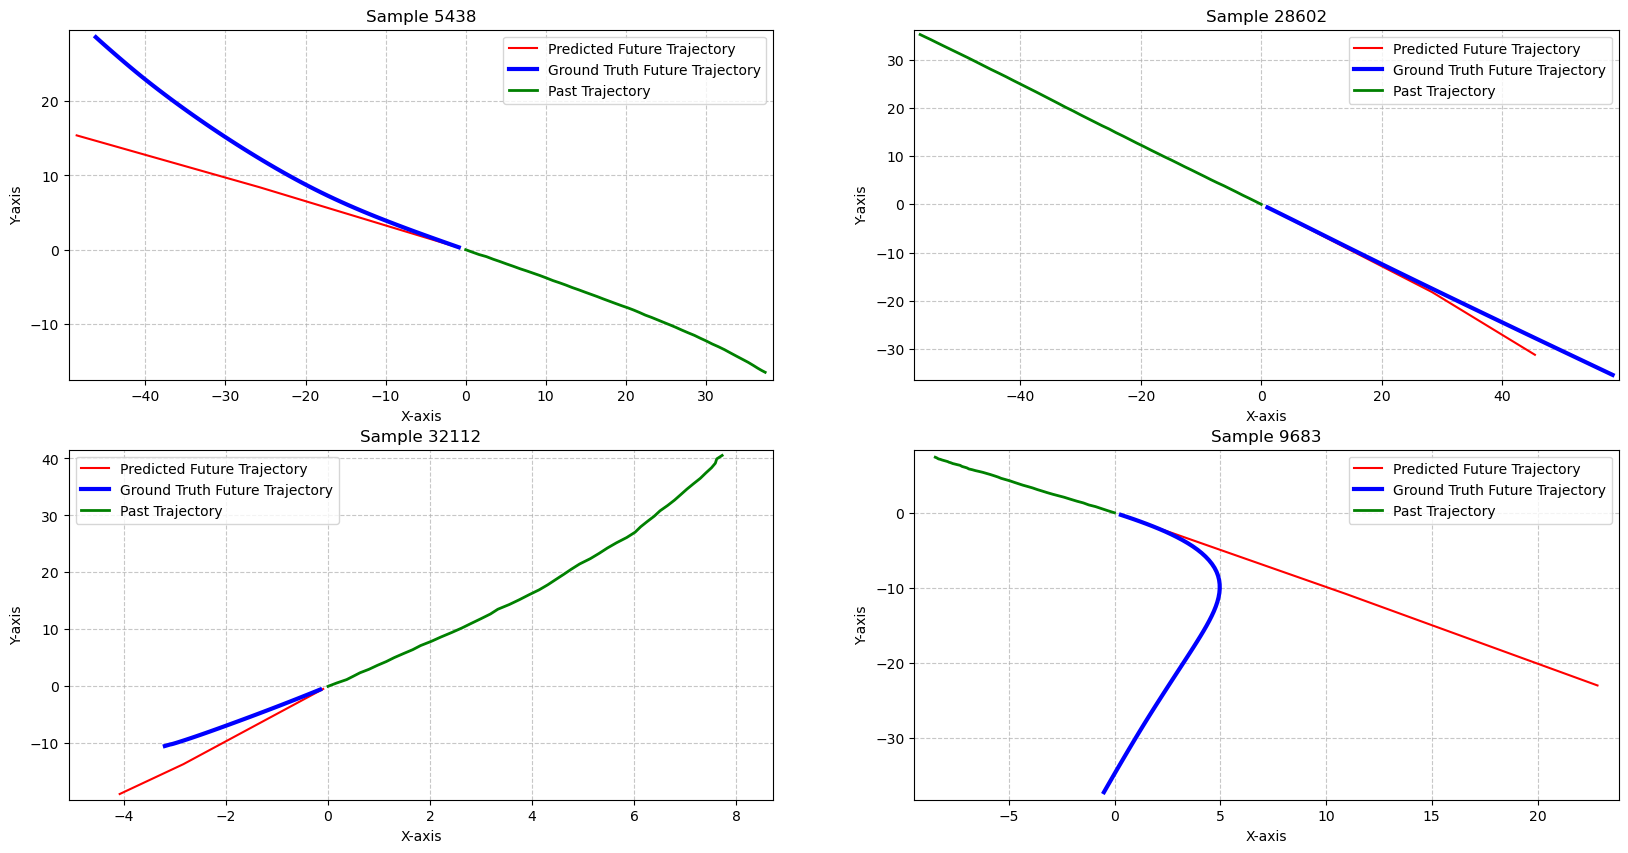

In [126]:
pred_y = predict(norm_model, val_x)

print(val_x.shape)
print(val_y.shape)
print(pred_y.shape)

def plot_trajectory(ax, past, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[:60,0], pred[:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[:60,0], gt[:60,1], color='blue', label='Ground Truth Future Trajectory', linewidth=3)

    ax.plot(past[:50, 0], past[:50, 1], color='green', label='Past Trajectory', linewidth=2)
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    x_max = max(x_max, past[..., 0].max())
    x_min = min(x_min, past[..., 0].min())
    y_max = max(y_max, past[..., 1].max())
    y_min = min(y_min, past[..., 1].min())
    
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

random_indices = random.sample(range(val_y.shape[0]), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects


for i, idx in enumerate(random_indices):

    x_deltas = val_x[idx][:49, 0]
    y_deltas = val_x[idx][:49, 1]
    
    # Reverse and negate deltas to walk backwards
    x_reversed_path = np.cumsum(x_deltas[::-1] * -1)[::-1]
    y_reversed_path = np.cumsum(y_deltas[::-1] * -1)[::-1]
    
    # Append origin (0, 0) at the end — corresponds to t=49
    x_full = np.append(x_reversed_path, 0)
    y_full = np.append(y_reversed_path, 0)
    
    # Stack into (50, 2) shape
    past_reconstructed = np.stack([x_full, y_full], axis=1)

    plot_trajectory(axes[i], past_reconstructed, pred_y[idx], val_y[idx], title=f"Sample {idx}")
    axes[i].legend()

plt.show()